# Feature Engineering Client

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('transactions_dataset.csv', sep=";")

In [3]:
df['date_order'] = pd.to_datetime(df['date_order'], format='%Y-%m-%d')

In [4]:
#filtered_df = df.loc[(df['date_order'] >= '2018-01-01') & (df['date_order'] <= '2018-12-31')]
filtered_df = df.copy()

In [5]:
print(filtered_df['date_order'].min())
print(filtered_df['date_order'].max())

2017-09-22 00:00:00
2019-09-22 00:00:00


In [6]:
filtered_df.shape

(63319315, 8)

In [7]:
filtered_df.drop_duplicates()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id
0,2017-09-25,2017-09-25,2376333,188502,155.44320,3,online,2732
1,2017-09-25,2017-09-25,2520527,835089,16.39440,3,at the store,10279
2,2017-09-25,2017-09-25,2536756,1977896,365.76624,21,online,6184
3,2017-09-25,2017-09-25,3028673,598816,8.59878,201,at the store,4200
4,2017-09-25,2017-09-25,203377,2086861,1093.37400,3,by phone,7051
...,...,...,...,...,...,...,...,...
63319310,2019-06-10,2020-06-12,1596284,245272,-2056.91300,5,by phone,7682
63319311,2018-12-14,2020-07-15,908253,880496,27.62760,1001,by phone,9375
63319312,2019-07-26,2020-10-29,1168247,2063314,-204.60984,101,by phone,3014
63319313,2018-05-23,2020-11-27,2319965,1287654,70.49730,17,by phone,1015


In [8]:
filtered_df = filtered_df.drop(['date_invoice'],axis=1)

In [9]:
filtered_df = filtered_df.drop(['order_channel'],axis=1)

In [10]:
filtered_df.head()

,date_order,product_id,client_id,sales_net,quantity,branch_id
0,2017-09-25,2376333,188502,155.44320,3,2732
1,2017-09-25,2520527,835089,16.39440,3,10279
2,2017-09-25,2536756,1977896,365.76624,21,6184
3,2017-09-25,3028673,598816,8.59878,201,4200
4,2017-09-25,203377,2086861,1093.37400,3,7051


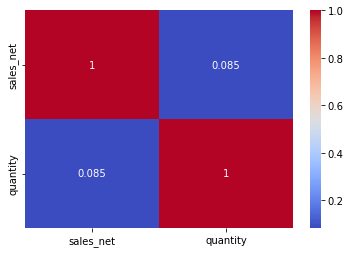

In [11]:
sns.heatmap(data=filtered_df[['date_order', 'sales_net','quantity']].corr(),
            annot=True, cmap='coolwarm');

In [12]:
# Checking for outliers

cols_for_distrib = ['sales_net','quantity',]

def outlier_function(df, col_name):
    ''' this function detects first and third quartile and interquartile range for a given column of a dataframe
    then calculates upper and lower limits to determine outliers conservatively
    returns the number of lower and uper limit and number of outliers respectively
    '''
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile+(3*IQR)
    lower_limit = first_quartile-(3*IQR)
    outlier_count = 0
                      
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

for x in cols_for_distrib:
    print(f"{x}: {outlier_function(filtered_df,x)[2]}")

sales_net: 4411763
quantity: 9812964


# Outlier Detection

<AxesSubplot:ylabel='sales_net'>

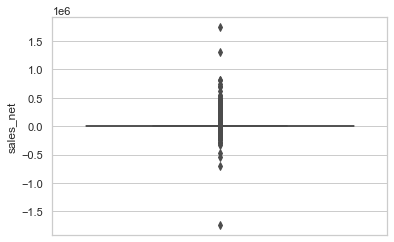

In [13]:
sns.set(style="whitegrid")
sns.boxplot(y=filtered_df['sales_net']) #sales_net is very sparse 

<AxesSubplot:ylabel='quantity'>

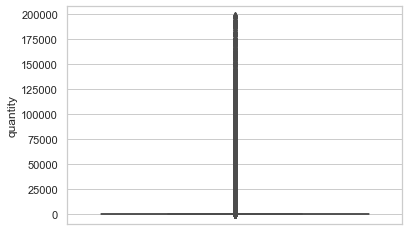

In [14]:
sns.set(style="whitegrid")
sns.boxplot(y=df['quantity'])

# Removing Outliers for sales_net

In [15]:
filtered_df = filtered_df[(filtered_df['sales_net'] > outlier_function(filtered_df,'sales_net')[0]) &
              (filtered_df['sales_net'] < outlier_function(filtered_df,'sales_net')[1])]
filtered_df.head()

,date_order,product_id,client_id,sales_net,quantity,branch_id
0,2017-09-25,2376333,188502,155.44320,3,2732
1,2017-09-25,2520527,835089,16.39440,3,10279
2,2017-09-25,2536756,1977896,365.76624,21,6184
3,2017-09-25,3028673,598816,8.59878,201,4200
5,2017-09-25,793319,564878,116.70384,11,35


In [16]:
filtered_df.shape

(58907546, 6)

In [17]:
filtered_df.nunique()

date_order        731
product_id     411447
client_id      168416
sales_net     1307082
quantity         2329
branch_id         576
dtype: int64

# Definiting Churn

In [18]:
#Calculating Recency

df_recency = filtered_df.groupby(by='client_id',
                        as_index=False)['date_order'].max()
df_recency.columns = ['client_id', 'LastPurchaseDate']
recent_date = df_recency['LastPurchaseDate'].max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(
    lambda x: (recent_date - x).days)
df_recency.head()

,client_id,LastPurchaseDate,Recency
0,6,2019-08-13,40
1,7,2018-12-24,272
2,14,2019-09-20,2
3,18,2019-09-12,10
4,25,2018-10-10,347


In [19]:
df_recency['I_Recency'] = 1/(df_recency['Recency']+1) #because the lower the recency the better and to avoid nulls
df_recency.head()

,client_id,LastPurchaseDate,Recency,I_Recency
0,6,2019-08-13,40,0.024390
1,7,2018-12-24,272,0.003663
2,14,2019-09-20,2,0.333333
3,18,2019-09-12,10,0.090909
4,25,2018-10-10,347,0.002874


In [20]:
df_recency.shape

(168416, 4)

In [21]:
#Calculating Frequency
frequency_df = filtered_df.groupby(
    by=['client_id'], as_index=False)['date_order'].nunique()
frequency_df.columns = ['client_id', 'Frequency']
frequency_df.head()

,client_id,Frequency
0,6,13
1,7,2
2,14,505
3,18,283
4,25,1


In [22]:
frequency_df.shape

(168416, 2)

In [23]:
#Calculating Monetary Value
monetary_df = filtered_df.groupby(by='client_id', as_index=False)['sales_net'].sum()
monetary_df.columns = ['client_id', 'Monetary']
monetary_df.head()

,client_id,Monetary
0,6,3.222781e+03
1,7,1.190777e+03
2,14,1.297435e+06
3,18,1.106206e+05
4,25,3.745861e+02


In [24]:
monetary_df.shape

(168416, 2)

In [25]:
monetary_df['Monetary']=monetary_df['Monetary'].astype('int64')

In [26]:
monetary_df.dtypes

client_id    int64
Monetary     int64
dtype: object

In [27]:
#Merging all three columns in one dataframe
rf_df = df_recency.merge(frequency_df, on='client_id')
rfm_df = rf_df.merge(monetary_df, on='client_id').drop(
    columns=['LastPurchaseDate'])
rfm_df.head()

,client_id,Recency,I_Recency,Frequency,Monetary
0,6,40,0.024390,13,3222
1,7,272,0.003663,2,1190
2,14,2,0.333333,505,1297435
3,18,10,0.090909,283,110620
4,25,347,0.002874,1,374


In [28]:
rfm_table = rfm_df.copy()

In [29]:
# Calculating Lifespan value
df_lifespam_max = filtered_df.groupby(by='client_id',
                        as_index=False)['date_order'].max()
df_lifespam_max.columns = ['client_id', 'LastPurchaseDate']

In [30]:
df_lifespam_max.head()

,client_id,LastPurchaseDate
0,6,2019-08-13
1,7,2018-12-24
2,14,2019-09-20
3,18,2019-09-12
4,25,2018-10-10


In [31]:
df_lifespam_max.shape

(168416, 2)

In [32]:
df_lifespam_min = filtered_df.groupby(by='client_id',
                        as_index=False)['date_order'].min()
df_lifespam_min.columns = ['client_id', 'FirstPurchaseDate']
df_lifespam_min.head()

,client_id,FirstPurchaseDate
0,6,2017-10-27
1,7,2018-07-16
2,14,2017-09-25
3,18,2017-09-26
4,25,2018-10-10


In [33]:
df_lifespam_min.shape

(168416, 2)

In [34]:
df_lifespam = df_lifespam_max.merge(df_lifespam_min, on='client_id')
df_lifespam.head()

,client_id,LastPurchaseDate,FirstPurchaseDate
0,6,2019-08-13,2017-10-27
1,7,2018-12-24,2018-07-16
2,14,2019-09-20,2017-09-25
3,18,2019-09-12,2017-09-26
4,25,2018-10-10,2018-10-10


In [35]:
df_lifespam.dtypes

client_id                     int64
LastPurchaseDate     datetime64[ns]
FirstPurchaseDate    datetime64[ns]
dtype: object

In [36]:
df_lifespam.shape

(168416, 3)

In [37]:
df_lifespam['lifespam'] = (df_lifespam['LastPurchaseDate'] - df_lifespam['FirstPurchaseDate'])

In [38]:
df_lifespam.head()

,client_id,LastPurchaseDate,FirstPurchaseDate,lifespam
0,6,2019-08-13,2017-10-27,655 days
1,7,2018-12-24,2018-07-16,161 days
2,14,2019-09-20,2017-09-25,725 days
3,18,2019-09-12,2017-09-26,716 days
4,25,2018-10-10,2018-10-10,0 days


In [39]:
df_lifespam['lifespam'] = df_lifespam['lifespam'].astype(str)

In [40]:
df_lifespam.head()

,client_id,LastPurchaseDate,FirstPurchaseDate,lifespam
0,6,2019-08-13,2017-10-27,655 days
1,7,2018-12-24,2018-07-16,161 days
2,14,2019-09-20,2017-09-25,725 days
3,18,2019-09-12,2017-09-26,716 days
4,25,2018-10-10,2018-10-10,0 days


In [41]:
df_lifespam['lifespam'] = df_lifespam["lifespam"].str.split(" days").str[0].astype(int)

In [42]:
df_lifespam.head()

,client_id,LastPurchaseDate,FirstPurchaseDate,lifespam
0,6,2019-08-13,2017-10-27,655
1,7,2018-12-24,2018-07-16,161
2,14,2019-09-20,2017-09-25,725
3,18,2019-09-12,2017-09-26,716
4,25,2018-10-10,2018-10-10,0


In [43]:
df_lifespam.dtypes

client_id                     int64
LastPurchaseDate     datetime64[ns]
FirstPurchaseDate    datetime64[ns]
lifespam                      int32
dtype: object

In [44]:
df_lifespam['lifespam'] = df_lifespam['lifespam'].astype('int64')

In [45]:
df_lifespam.dtypes

client_id                     int64
LastPurchaseDate     datetime64[ns]
FirstPurchaseDate    datetime64[ns]
lifespam                      int64
dtype: object

In [46]:
#Merging all three columns in one dataframe
rfm_lifespam = rfm_df.merge(df_lifespam, on='client_id')
rfm_lifespam.head()

,client_id,Recency,I_Recency,Frequency,Monetary,LastPurchaseDate,FirstPurchaseDate,lifespam
0,6,40,0.024390,13,3222,2019-08-13,2017-10-27,655
1,7,272,0.003663,2,1190,2018-12-24,2018-07-16,161
2,14,2,0.333333,505,1297435,2019-09-20,2017-09-25,725
3,18,10,0.090909,283,110620,2019-09-12,2017-09-26,716
4,25,347,0.002874,1,374,2018-10-10,2018-10-10,0


In [47]:
rfm_lifespam.shape

(168416, 8)

In [48]:
rfm_lifespam = rfm_lifespam.drop(['LastPurchaseDate', 'FirstPurchaseDate'], axis=1)
rfm_lifespam.head()

,client_id,Recency,I_Recency,Frequency,Monetary,lifespam
0,6,40,0.024390,13,3222,655
1,7,272,0.003663,2,1190,161
2,14,2,0.333333,505,1297435,725
3,18,10,0.090909,283,110620,716
4,25,347,0.002874,1,374,0


In [49]:
rfm_lifespam.shape

(168416, 6)

In [50]:
rfm_lifespam.dtypes

client_id      int64
Recency        int64
I_Recency    float64
Frequency      int64
Monetary       int64
lifespam       int64
dtype: object

In [51]:
#Calculating CLV
clv_df = filtered_df.groupby(by='client_id', as_index=False)['sales_net'].mean()
clv_df.columns = ['client_id', 'monetary_avg']
clv_df.head()

,client_id,monetary_avg
0,6,89.521686
1,7,79.385139
2,14,115.348083
3,18,52.130358
4,25,93.646524


In [52]:
clv_df['monetary_avg']=clv_df['monetary_avg'].astype('int64')
clv_df.dtypes

client_id       int64
monetary_avg    int64
dtype: object

In [53]:
clv_df.shape

(168416, 2)

In [54]:
#Merging all three columns in one dataframe
clv = clv_df.merge(frequency_df, on='client_id')
clv.head()

,client_id,monetary_avg,Frequency
0,6,89,13
1,7,79,2
2,14,115,505
3,18,52,283
4,25,93,1


In [55]:
clv['clv'] = clv['monetary_avg'] * clv['Frequency']
clv.head()

,client_id,monetary_avg,Frequency,clv
0,6,89,13,1157
1,7,79,2,158
2,14,115,505,58075
3,18,52,283,14716
4,25,93,1,93


In [56]:
clv.shape

(168416, 4)

In [57]:
del clv['Frequency']

In [58]:
clv.head()

,client_id,monetary_avg,clv
0,6,89,1157
1,7,79,158
2,14,115,58075
3,18,52,14716
4,25,93,93


In [59]:
rfm = rfm_lifespam.merge(clv, on='client_id')
rfm.head()

,client_id,Recency,I_Recency,Frequency,Monetary,lifespam,monetary_avg,clv
0,6,40,0.024390,13,3222,655,89,1157
1,7,272,0.003663,2,1190,161,79,158
2,14,2,0.333333,505,1297435,725,115,58075
3,18,10,0.090909,283,110620,716,52,14716
4,25,347,0.002874,1,374,0,93,93


In [60]:
del rfm['monetary_avg']

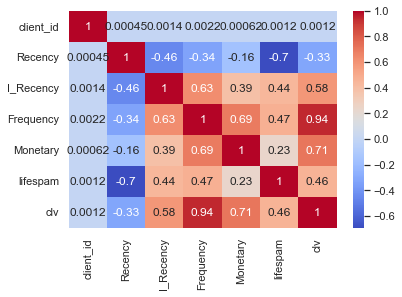

In [61]:
sns.heatmap(data=rfm[['client_id', 'Recency', 'I_Recency','Frequency','Monetary','lifespam','clv']].corr(),
            annot=True, cmap='coolwarm');

In [62]:
rfm1 = rfm.copy()

In [63]:
# Dropping Frequency column as it is highly correlated with clv and recency and i_recency we know the correlation is 1 but will
#keep them for the comparisons

del rfm1['Frequency']

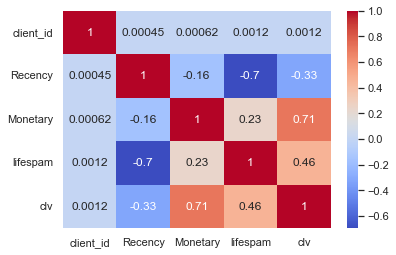

In [64]:
sns.heatmap(data=rfm[['client_id', 'Recency','Monetary','lifespam','clv']].corr(),
            annot=True, cmap='coolwarm');

In [65]:
# Checking for outliers

cols_for_distrib = ['client_id', 'Recency','Monetary','lifespam','clv']

def outlier_function(df, col_name):
    ''' this function detects first and third quartile and interquartile range for a given column of a dataframe
    then calculates upper and lower limits to determine outliers conservatively
    returns the number of lower and uper limit and number of outliers respectively
    '''
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile+(3*IQR)
    lower_limit = first_quartile-(3*IQR)
    outlier_count = 0
                      
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

for x in cols_for_distrib:
    print(f"{x}: {outlier_function(rfm1,x)[2]}")

client_id: 0
Recency: 0
Monetary: 16008
lifespam: 0
clv: 13014


# Outlier detection for the new features

<AxesSubplot:ylabel='Monetary'>

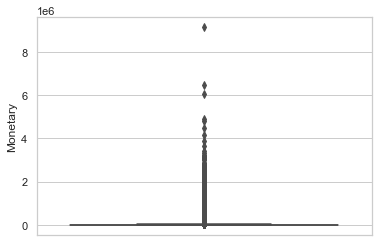

In [66]:
sns.set(style="whitegrid")
sns.boxplot(y=rfm1['Monetary'])

<AxesSubplot:ylabel='clv'>

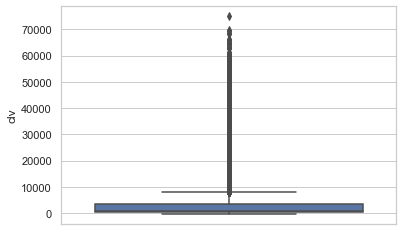

In [67]:
sns.set(style="whitegrid")
sns.boxplot(y=rfm1['clv'])

<AxesSubplot:xlabel='lifespam', ylabel='clv'>

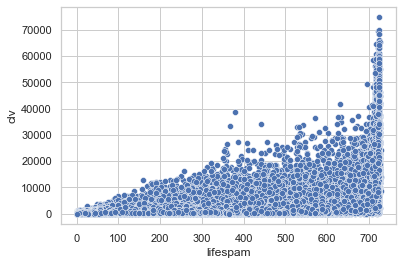

In [68]:
sns.scatterplot(x=rfm1['lifespam'], y=rfm1['clv'])

<AxesSubplot:xlabel='Monetary', ylabel='clv'>

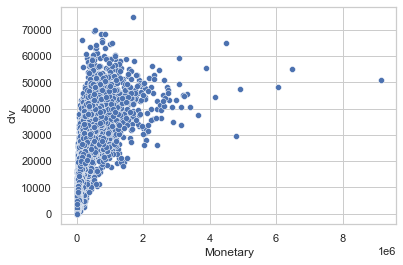

In [69]:
sns.scatterplot(x=rfm1['Monetary'], y=rfm1['clv'])

In [70]:
rfm1 = rfm1[(rfm1['Monetary'] > outlier_function(rfm1,'Monetary')[0]) &
              (rfm1['Monetary'] < outlier_function(rfm1,'Monetary')[1])]
rfm1.head() #remove outliers of monetary 

,client_id,Recency,I_Recency,Monetary,lifespam,clv
0,6,40,0.024390,3222,655,1157
1,7,272,0.003663,1190,161,158
4,25,347,0.002874,374,0,93
5,37,109,0.009091,2803,568,780
6,40,20,0.047619,14889,707,4418


In [71]:
rfm1.shape

(152407, 6)

<AxesSubplot:xlabel='Monetary', ylabel='clv'>

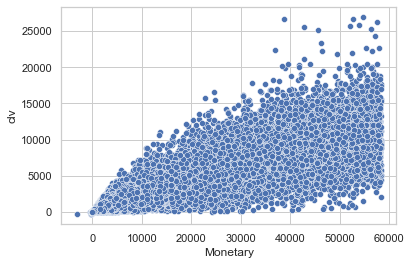

In [72]:
sns.scatterplot(x=rfm1['Monetary'], y=rfm1['clv'])

# Defining Churn

In [73]:
#sample of quartile analysis we will use
print(rfm1.clv.mean(),
rfm1.clv.median(),
rfm1.clv.quantile(0.25),
rfm1.clv.quantile(0.5), 
rfm1.clv.quantile(0.75))

1771.5527961314112 704.0 220.0 704.0 2209.0


In [74]:
def score(x,p,d):
    if x <= d[p][0.25]:
        return 1
    if x <= d[p][0.5] and x >d[p][0.25]:
        return 2
    if x <= d[p][0.75] and x >d[p][0.5]: 
        return 3
    if x >d[p][0.75]:
        return 4

In [75]:
quantiles = rfm1.quantile(q=[0.25,0.50,0.75])
quantiles

,client_id,Recency,I_Recency,Monetary,lifespam,clv
0.25,569789.0,18.0,0.003623,660.0,112.0,220.0
0.50,1139006.0,65.0,0.015152,2649.0,458.0,704.0
0.75,1709773.5,275.0,0.052632,9537.0,668.0,2209.0


In [76]:
quantiles = quantiles.to_dict()
rfm1['clv_Tile'] = rfm1['clv'].apply(score, args=('clv',quantiles))

In [77]:
rfm1['clv_Tile'].value_counts()

2    38192
1    38124
4    38100
3    37991
Name: clv_Tile, dtype: int64

In [78]:
def score_recency(x,p,d):
    if x <= d[p][0.25]:
        return 4
    if x <= d[p][0.5] and x >d[p][0.25]:
        return 3
    if x <= d[p][0.75] and x >d[p][0.5]: 
        return 2
    if x >d[p][0.75]:
        return 1

In [79]:
rfm1['Rec_Tile'] = rfm1['Recency'].apply(score_recency, args=('Recency',quantiles,))

In [80]:
rfm1['Rec_Tile'].value_counts()

4    39390
1    38101
2    37629
3    37287
Name: Rec_Tile, dtype: int64

In [81]:
rfm1['I_Rec_Tile'] = rfm1['I_Recency'].apply(score, args=('I_Recency',quantiles))

In [82]:
rfm1['I_Rec_Tile'].value_counts()

3    39266
1    38276
2    37960
4    36905
Name: I_Rec_Tile, dtype: int64

In [83]:
rfm1['Mone_Tile'] = rfm1['Monetary'].apply(score, args=('Monetary',quantiles,))
rfm1['Mone_Tile'].value_counts()

1    38108
2    38102
4    38099
3    38098
Name: Mone_Tile, dtype: int64

In [84]:
rfm1['lifespam_Tile'] = rfm1['lifespam'].apply(score, args=('lifespam',quantiles,))
rfm1['lifespam_Tile'].value_counts()

2    38168
1    38112
4    38096
3    38031
Name: lifespam_Tile, dtype: int64

In [85]:
# Add to dataframe - we will use only the ones of I_Rec not Rec
rfm1['score_v1'] = rfm1['clv_Tile'].map(str) + rfm1['I_Rec_Tile'].map(str) + rfm1['Mone_Tile'].map(str) + rfm1['lifespam_Tile'].map(str)
rfm1.head()

,client_id,Recency,I_Recency,Monetary,lifespam,clv,clv_Tile,Rec_Tile,I_Rec_Tile,Mone_Tile,lifespam_Tile,score_v1
0,6,40,0.024390,3222,655,1157,3,3,3,3,3,3333
1,7,272,0.003663,1190,161,158,1,2,2,2,2,1222
4,25,347,0.002874,374,0,93,1,1,1,1,1,1111
5,37,109,0.009091,2803,568,780,3,2,2,3,3,3233
6,40,20,0.047619,14889,707,4418,4,3,3,4,4,4344


In [86]:
rfm1.score_v1.min()

'1111'

In [87]:
#Who are the lost customers?

#Customers who's recency, frequency as well as monetary values are low 

rfm1[rfm1['score_v1'] == '1111'].sort_values('I_Recency',ascending=False).count()

client_id        14830
Recency          14830
I_Recency        14830
Monetary         14830
lifespam         14830
clv              14830
clv_Tile         14830
Rec_Tile         14830
I_Rec_Tile       14830
Mone_Tile        14830
lifespam_Tile    14830
score_v1         14830
dtype: int64

In [88]:
#Summing the RFM Score
rfm1['score'] = rfm1[['clv_Tile','I_Rec_Tile','Mone_Tile','lifespam_Tile']].sum(axis=1)
rfm1.head()

,client_id,Recency,I_Recency,Monetary,lifespam,clv,clv_Tile,Rec_Tile,I_Rec_Tile,Mone_Tile,lifespam_Tile,score_v1,score
0,6,40,0.024390,3222,655,1157,3,3,3,3,3,3333,12
1,7,272,0.003663,1190,161,158,1,2,2,2,2,1222,7
4,25,347,0.002874,374,0,93,1,1,1,1,1,1111,4
5,37,109,0.009091,2803,568,780,3,2,2,3,3,3233,11
6,40,20,0.047619,14889,707,4418,4,3,3,4,4,4344,15


In [89]:
print(rfm1.score.mean(),
rfm1.score.median(),
rfm1.score.max(),
rfm1.score.min(),     
rfm1.score.quantile(0.25),
rfm1.score.quantile(0.5), 
rfm1.score.quantile(0.75))

9.989186848373107 10.0 16 4 7.0 10.0 13.0


In [90]:
rfm1.score.value_counts()

16    16619
4     14830
11    12999
5     12298
9     12058
7     11493
13    11054
15    10648
6     10577
10    10312
12    10107
8      9885
14     9527
Name: score, dtype: int64

In [91]:
def score_level(df):
    if df['score']<=7:
        return 'Churned'
    if df['score'] >7 and df['score'] <=10:
        return 'Regular'
    if df['score'] >10 and df['score'] <=13:
        return 'Loyal'
    if df['score'] >13:
        return 'Premium'

In [92]:
# Create a new variable RFM_Level
rfm1['score_level'] = rfm1.apply(score_level, axis=1)

# Print the header with top 5 rows to the console
rfm1.head()

,client_id,Recency,I_Recency,Monetary,lifespam,clv,clv_Tile,Rec_Tile,I_Rec_Tile,Mone_Tile,lifespam_Tile,score_v1,score,score_level
0,6,40,0.024390,3222,655,1157,3,3,3,3,3,3333,12,Loyal
1,7,272,0.003663,1190,161,158,1,2,2,2,2,1222,7,Churned
4,25,347,0.002874,374,0,93,1,1,1,1,1,1111,4,Churned
5,37,109,0.009091,2803,568,780,3,2,2,3,3,3233,11,Loyal
6,40,20,0.047619,14889,707,4418,4,3,3,4,4,4344,15,Premium


In [93]:
rfm1.to_csv('client_clustering_2.csv', sep=',', index = False)

In [94]:
rfm1["score_level"].value_counts()

Churned    49198
Premium    36794
Loyal      34160
Regular    32255
Name: score_level, dtype: int64

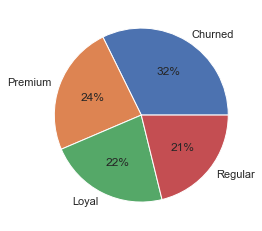

In [95]:
plt.pie(rfm1.score_level.value_counts(),
        labels=rfm1.score_level.value_counts().index,
        autopct='%.0f%%')
plt.show()